# Time series analysis  (trend, slope, ... calculation) for JEDI-CUBES

This notebook was set up to help with the analysis of time series in jedi cubes. It can be connected directly to JEDI cubes and examine a time series contained there for various reference units (NUTS3,2,1,0, 1km, 10km, ....).
If you have any questions, please contact: loehnertz@space4environment.com

---------------------------------------------------------------------------------------------------------------------------------------


## (1) connection to jedi cube tables on MS-SQL (TEAL and  GREENMONKEY)
    !Please note: you need read and partially write permissions for the database to be used.!
        
<img src="./images/ms_sql_server_image.png" style="height: 600px;"/>

In [1]:
# Reading libaries and start a test-connection to different MS-SQL Server:
import pyodbc 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sqlalchemy as sa
from sqlalchemy import create_engine, event
from sqlalchemy.engine.url import URL
import json

from scipy import stats

#check processing time:##
import time  
import datetime
start_time = time.time()
##########################

#### TEAL
print ("----------------------------------------------------------------")
print ("connect to engine TEAL")
### reading psw and name:
with open(r"S:\Common workspace\ETC_DI\f07_JUPYTER_NOTEBOOKS\teal_account.txt") as f:  variables = json.load(f)
SERVERNAME =  (variables["server"])
USERNAME =  (variables["user"])
PSSWD =  (variables["psw"])
DRIVER = "ODBC Driver 17 for SQL Server"
#INSTANCENAME = "\SQLEXPRESS"
DB = "master"
#TABLE = "perftest"

engine_TEAL = sa.create_engine(
    f"mssql+pyodbc://{USERNAME}:{PSSWD}@{SERVERNAME}/{DB}?driver={DRIVER}", fast_executemany=True)       
#pd.set_option('display.max_rows', None)  ## display ALL ROWS -https://stackoverflow.com/questions/25351968/how-can-i-display-full-non-truncated-dataframe-information-in-html-when-conver
#readable_database = pd.read_sql(query_check, engine_TEAL)
#print(readable_database)

print ("----------------------------------------------------------------")

print ("connect to engine GREENMONKEY")

engine_GREENMONKEY = sa.create_engine('mssql+pyodbc://' + "GREENMONKEY" + '/' + "tempdb" + '?trusted_connection=yes&driver=ODBC+Driver+13+for+SQL+Server')

connection = engine_GREENMONKEY.raw_connection()
cursor = connection.cursor()

print ("connection to greenmonkey found")
print ("the function HAS_DBACCESS returns 1 if the user has access to the database, otherwise, it will return as 0")  

#readable_database = pd.read_sql(query_check, engine_GREENMONKEY)
#cursor.execute(query_check)
#cursor.close()
#connection.commit()
print ("following databases can be READ:")
#print (readable_database)
print ("----------------------------------------------------------------")




print ("end....")
print("--- %s seconds ---" % (time.time() - start_time))
seconds = time.time() - start_time
print('Time Taken: HH:MM:SS ', time.strftime("%H:%M:%S",time.gmtime(seconds)))

----------------------------------------------------------------
connect to engine TEAL
----------------------------------------------------------------
connect to engine GREENMONKEY
connection to greenmonkey found
the function HAS_DBACCESS returns 1 if the user has access to the database, otherwise, it will return as 0
following databases can be READ:
----------------------------------------------------------------
end....
--- 0.4465334415435791 seconds ---
Time Taken: HH:MM:SS  00:00:00


-------------------------------

## (2)Read and transform table on 


### (2.0) Slope of all  LINT anomalies

The following script harvested the drought data from TEAL (cube F/C table) and calculated the slope of all LINT anomalies:

In [84]:
### The following script harvested the drought data from TEAL (cube F/C table) and calculated the slope of all LINT anomalies:
print ("START READING data from the CUBE on TEA -->  [JEDI_DroughtImpact2022].[dbo].[C_DroughtImpact2022]L")
print ("----------------------------------------------------------------")


## SQL query  (check if we need a group by - because the cube has more line: CLC06,,,,)
query_LINT_anom=('''
SELECT 
      [Admin]
      ,[Env]
      ,[CLC18]
	  ,[CLC00]
      ,[CLC0018]
      ,[LINT_anom_2000]
      ,[LINT_anom_2001]
      ,[LINT_anom_2002]
      ,[LINT_anom_2003]
      ,[LINT_anom_2004]
      ,[LINT_anom_2005]
      ,[LINT_anom_2006]
      ,[LINT_anom_2007]
      ,[LINT_anom_2008]
      ,[LINT_anom_2009]
      ,[LINT_anom_2010]
      ,[LINT_anom_2011]
      ,[LINT_anom_2012]
      ,[LINT_anom_2013]
      ,[LINT_anom_2014]
      ,[LINT_anom_2015]
      ,[LINT_anom_2016]
      ,[LINT_anom_2017]
      ,[LINT_anom_2018]
      ,[LINT_anom_2019]
      ,[LINT_anom_2020]
      ,[LINT_anom_2021]
      ,[AreaHa]
  FROM [JEDI_DroughtImpact2022].[dbo].[C_DroughtImpact2022]
 
where Admin is not null
--- where Admin = 1521    
 
 
 
    ''')  

df_LINT_anom = pd.read_sql(query_LINT_anom, engine_TEAL)

print ("table read from TEAL job done")
## Tronsforme the table columns to rows:
df_transformed =df_LINT_anom.melt(id_vars=['Admin', 'Env', 'CLC00', 'CLC18', 'CLC0018','AreaHa'], 
     var_name="year_string", 
       value_name="LINT_anom_values")

print ("table TRANSFORMED -pivot- job done")
##Convert the Strings to Datetime in the DataFrame
#count_row = df_transformed.shape[0]  # Gives number of rows
#count_col = df_transformed.shape[1]  # Gives number of columns#

#print ('number of rows: ' + str(count_row))
#print ('number of columns: ' + str(count_col))


##cleaning the table: change the year from string to INT or DATE-format:
df_transformed['year_string_number'] = df_transformed['year_string'].str[-4:]
df_transformed['year'] = df_transformed['year_string_number'].astype(int)
df_transformed.drop(['year_string_number'], axis=1)
#df_transformed['year'] = pd.to_datetime(df_transformed['year'], format='%Y')
print ("year value updated done")


######################################## calcualtion slope,...

## group ############################################################### =['Admin', 'Env', 'CLC00', 'CLC18','AreaHa']

## here we are doing a groupby -(in the moment we have also lines for CLC06, CL12,) --> group by can also be done during SQL reading
dfg = df_transformed.groupby(["Admin","Env","CLC00","CLC18","year"]).agg({'AreaHa' : ['sum'], 'LINT_anom_values' : ['mean']}).reset_index()  # this function do a group by and calc. the sum area and min,max,avg for LINT
#cleaning columns:
dfg.columns = ["_".join(x) for x in dfg.columns.ravel()]
dfg = dfg.rename(columns={'Admin_': 'Admin', 'Env_': 'Env', 'CLC00_': 'CLC00', 'CLC18_': 'CLC18', 'year_': 'year'}).reset_index()#.sort_values(ascending=True)
# calculate weighted AVG:
#dfg['LINT_anom_values_weightavg'] =dfg['AreaHa_sum'] * dfg['LINT_anom_values_mean']   ## not needed for C-tables 


################################################################################# model start
# model for calculation trend:  https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.linregress.html
def model_trend_stat(row):
    y = row.LINT_anom_values_mean
    x = row.year
    count_rows = len(row)  ## better to work with index (loc).but for the moment ok
    year_min=min(x)
    year_max=max(x)
    

    ##testing index...but not working...
    #y_start = row['LINT_anom_values_mean'][row['LINT_anom_values_mean']  == year_min].index.tolist()
    #y_start =dfg.loc[row['LINT_anom_values_mean'] == 2]
    #y_end = row.loc[row['LINT_anom_values_mean'] == year_max]  #.index[0]
                        

    y_end = row['LINT_anom_values_mean'].values[count_rows-1]  # get the las value in the group
    y_start = row['LINT_anom_values_mean'].values[0]  # get the first value in the group    
    
    #slope_change = (y_end - y_start) / y_start  ### cehck divide by zero
    if y_start != 0: 
        slope_change = (y_end - y_start) / y_start
    else:
        slope_change = 0
    
    m = stats.linregress(x,y)
    slope =m.slope 
    intercept=m.intercept
    rvalue=m.rvalue
    pvalue=m.pvalue
    stderr=m.stderr
    intercept_stderr=m.intercept_stderr

    t = [m.slope * i + m.intercept for i in x]  
    #return pd.Series([rvalue,slope,intercept,pvalue,stderr])
    return pd.Series({'rvalue': rvalue, 'slope':slope,'intercept':intercept,'pvalue':pvalue,'stderr':stderr, 'yearMIN': year_min,'yearMAX': year_max,'y_start': y_start,'y_end': y_end,'slope_change': slope_change})
################################################################################# model end

#calcualtion of slope, trend,... for every group : (reference unit):
dfg_trend= dfg.groupby(["Admin", "Env","CLC00","CLC18"]).apply(model_trend_stat).reset_index()#.sort_values(ascending=False)




#exporting data to GREENMONKEY#################################################################################
print ("connect to engine GREENMONKEY")  #drought
engine_GREENMONKEY = sa.create_engine('mssql+pyodbc://' + "GREENMONKEY" + '/' + "Climate_Impact" + '?trusted_connection=yes&driver=ODBC+Driver+13+for+SQL+Server')
name_of_table ="C_DroughtImpact2022_with_years_LINT_anom_slope_T01"       
print ("connect to greenmonkey engine.....GREENMONKEY and store sql table")  
dfg_trend.to_sql(name_of_table, engine_GREENMONKEY, if_exists='replace', index = False, schema='drought')

##################################################################################################################



print("--- %s seconds ---" % (time.time() - start_time))
seconds = time.time() - start_time
print('Time Taken: HH:MM:SS ', time.strftime("%H:%M:%S",time.gmtime(seconds)))
print ("end....")


START READING data from the CUBE on TEA -->  [JEDI_DroughtImpact2022].[dbo].[C_DroughtImpact2022]L
----------------------------------------------------------------
table read from TEAL job done
table TRANSFORMED -pivot- job done
year value updated done


C:\Program Files\ArcGIS\Pro\bin\Python\envs\arcgispro-py3\lib\site-packages\ipykernel_launcher.py:78: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.


connect to engine GREENMONKEY
connect to greenmonkey engine.....GREENMONKEY and store sql table
--- 11213.533267498016 seconds ---
Time Taken: HH:MM:SS  03:06:53
end....


# QC of the results:

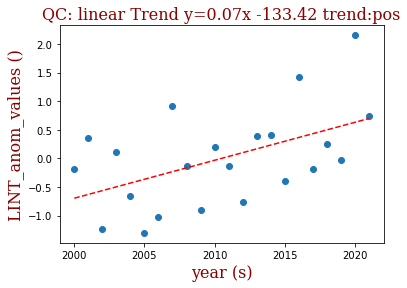

---
       year  LINT_anom_values
686    2000         -0.189579
1374   2001          0.352035
2062   2002         -1.241081
2750   2003          0.115849
3438   2004         -0.654902
4126   2005         -1.303506
4814   2006         -1.026347
5502   2007          0.908999
6190   2008         -0.132348
6878   2009         -0.905185
7566   2010          0.201303
8254   2011         -0.126323
8942   2012         -0.755622
9630   2013          0.389780
10318  2014          0.401049
11006  2015         -0.397640
11694  2016          1.422845
12382  2017         -0.183693
13070  2018          0.245721
13758  2019         -0.024256
14446  2020          2.153339
15134  2021          0.749561
'''''''''''''''''''''''''''''''''''''''''''''''''''''''''
    Admin  Env  CLC00  CLC18    rvalue     slope   intercept    pvalue  \
19   1521  LUS    211    211  0.510332  0.066364 -133.424991  0.015237   

      stderr  yearMIN  yearMAX   y_start     y_end  slope_change  
19  0.025006   2000.0   2021.0 -

In [80]:
## checking results:
## how pandas works: https://pandas.pydata.org/docs/getting_started/intro_tutorials/03_subset_data.html

###########################INPUT SELECTION for QC:

###########################


## Results:############################################################################
filter_dfg= dfg_trend[   (dfg_trend['Admin']  == ADMIN) 
                       & (dfg_trend['Env']  == ENV_code) 
                       & (dfg_trend['CLC00']  == CLC2000) 
                       & (dfg_trend['CLC18']==  CLC2018)     ]
## for the plot :
slope= filter_dfg.iloc[0]['slope'] 
intercept= filter_dfg.iloc[0]['intercept'] 
plot_trend = "y="+str(round(slope,2))+"x "+str(round(intercept,2))
if slope >0: 
    trend="pos"
elif slope ==0:
    trend="neutral"
elif slope <0:
    trend="negativ"

## Raw datacube:############################################################################
filter_df_LINT_anom_cube=  df_LINT_anom[    (df_LINT_anom['Admin']  == ADMIN) 
                                           & (df_LINT_anom['Env']  == ENV_code) 
                                           & (df_LINT_anom['CLC00']  == CLC2000) 
                                           & (df_LINT_anom['CLC18']==  CLC2018)   ] 





## Transoformed table:############################################################################
filter_df_transformed =  df_transformed[    (df_transformed['Admin']  == ADMIN) 
                                           & (df_transformed['Env']  == ENV_code) 
                                           & (df_transformed['CLC00']  == CLC2000) 
                                          & (df_transformed['CLC18']==  CLC2018)   ] 



###PLOT:###############################################PLOTSTART
font = {'family': 'serif',
        'color':  'darkred',
        'weight': 'normal',
        'size': 16,
        }

x = filter_df_transformed['year']
y=  filter_df_transformed['LINT_anom_values']
plt.scatter(x, y)
z = np.polyfit(x, y, 1)
p = np.poly1d(z)
plt.plot(x,p(x),"r--")

plt.title('QC: linear Trend '+plot_trend +' trend:'+trend, fontdict=font)
#plt.text(2010, 1, plot_trend, fontdict=font)
plt.xlabel('year (s)', fontdict=font)
plt.ylabel('LINT_anom_values ()', fontdict=font)
plt.subplots_adjust(left=0.15)
plt.show()


print ("---")

print (filter_df_transformed[['year','LINT_anom_values']])
###PLOT:###############################################PLOTEND
print ("'''''''''''''''''''''''''''''''''''''''''''''''''''''''''")
print(filter_dfg)
print ("'''''''''''''''''''''''''''''''''''''''''''''''''''''''''")
print ("")
print ("")
print ("please open tableau on CWS: ")
print ("S:\Common workspace\ETC_DI\AP22_Drought\Tableau\Testing-slope.twb")

####################################################################################################

In [81]:
filter_dfg
#dfg

,Admin,Env,CLC00,CLC18,rvalue,slope,intercept,pvalue,stderr,yearMIN,yearMAX,y_start,y_end,slope_change
19,1521,LUS,211,211,0.510332,0.066364,-133.424991,0.015237,0.025006,2000.0,2021.0,-0.189579,0.749561,-4.953824


In [123]:
#filter_df_transformed  ystart year(bin) yend year(max)

year
filter_df_transformed.min()


,Admin,Env,CLC00,CLC18,CLC0018,AreaHa,year_string,LINT_anom_values,year_string_number,year
60923,1521.0,LUS,111.0,111.0,111111.0,452.0,LINT_anom_2000,-0.268388,2000,2000
241493,1521.0,LUS,111.0,111.0,111111.0,452.0,LINT_anom_2001,0.204335,2001,2001
422063,1521.0,LUS,111.0,111.0,111111.0,452.0,LINT_anom_2002,-1.403243,2002,2002
602633,1521.0,LUS,111.0,111.0,111111.0,452.0,LINT_anom_2003,-0.015039,2003,2003
783203,1521.0,LUS,111.0,111.0,111111.0,452.0,LINT_anom_2004,-0.783699,2004,2004
963773,1521.0,LUS,111.0,111.0,111111.0,452.0,LINT_anom_2005,-1.670003,2005,2005
1144343,1521.0,LUS,111.0,111.0,111111.0,452.0,LINT_anom_2006,-0.652175,2006,2006
1324913,1521.0,LUS,111.0,111.0,111111.0,452.0,LINT_anom_2007,0.070922,2007,2007
1505483,1521.0,LUS,111.0,111.0,111111.0,452.0,LINT_anom_2008,-0.192294,2008,2008
1686053,1521.0,LUS,111.0,111.0,111111.0,452.0,LINT_anom_2009,-0.810070,2009,2009


# ANNEX

### (2.1) SMA-1 LINT-05 Area 

In [2]:
## Transform table

##SMA1LINT0Area_2019
print ("SMA-1 LINT-05 Area")
start_time = time.time()
current_start_time = datetime.datetime.now()
print ("START time at greenwich:", current_start_time)
sql_sma1_lint05_area = (
'''SELECT [Admin], Env, CLC00, CLC18, CLC0018, 
 SMA1LINT05Area_2000, SMA1LINT05Area_2001, SMA1LINT05Area_2002, SMA1LINT05Area_2003, 
 SMA1LINT05Area_2004, SMA1LINT05Area_2005, SMA1LINT05Area_2006, SMA1LINT05Area_2007, SMA1LINT05Area_2008,
 SMA1LINT05Area_2009, SMA1LINT05Area_2010, SMA1LINT05Area_2011, SMA1LINT05Area_2012, SMA1LINT05Area_2013, 
 SMA1LINT05Area_2014, SMA1LINT05Area_2015, SMA1LINT05Area_2016, SMA1LINT05Area_2017, SMA1LINT05Area_2018,
 SMA1LINT05Area_2019, SMA1LINT05Area_2020, SMA1LINT05Area_2021, 
 AreaHa
  FROM [Climate_Impact].[drought].[C_DroughtImpact2022_assessment_version_v1]
  
  where Admin = 1521    ---  #Nuts: PT11D (AMD: 1521)
  ''')


readable_sql = pd.read_sql(sql_sma1_lint05_area, engine_GREENMONKEY)  ##reading table into data-frame df


print ("job done")

df_transformed =readable_sql.melt(id_vars=['Admin', 'Env', 'CLC00', 'CLC18', 'CLC0018','AreaHa'], 
     var_name="fire_parameter_and_year", 
        value_name="drought_area")


##Convert the Strings to Datetime in the DataFrame
count_row = df_transformed.shape[0]  # Gives number of rows
count_col = df_transformed.shape[1]  # Gives number of columns

print ('number of rows: ' + str(count_row))
print ('number of columns: ' + str(count_col))


##cleaning the table
df_transformed['yeart'] = df_transformed['fire_parameter_and_year'].str[-4:]
df_transformed['year'] = df_transformed['yeart'].astype(int)
df_transformed.drop(['yeart'], axis=1)
#df_transformed['year'] = pd.to_datetime(df_transformed['year'], format='%Y')




print ("done")

print("--- %s seconds ---" % (time.time() - start_time))
seconds = time.time() - start_time
print('Time Taken: HH:MM:SS ', time.strftime("%H:%M:%S",time.gmtime(seconds)))
print ("end....")


SMA-1 LINT-05 Area
START time at greenwich: 2023-04-26 12:18:39.458630
job done
number of rows: 7458
number of columns: 8
done
--- 0.12758350372314453 seconds ---
Time Taken: HH:MM:SS  00:00:00
end....


In [3]:
df_transformed

,Admin,Env,CLC00,CLC18,CLC0018,AreaHa,fire_parameter_and_year,drought_area,yeart,year
0,1521,LUS,112.0,112.0,112112.0,2161.0,SMA1LINT05Area_2000,0.0,2000,2000
1,1521,LUS,142.0,122.0,142122.0,2.0,SMA1LINT05Area_2000,0.0,2000,2000
2,1521,LUS,221.0,121.0,221121.0,13.0,SMA1LINT05Area_2000,0.0,2000,2000
3,1521,LUS,222.0,133.0,222133.0,4.0,SMA1LINT05Area_2000,0.0,2000,2000
4,1521,LUS,311.0,324.0,311324.0,324.0,SMA1LINT05Area_2000,0.0,2000,2000
...,...,...,...,...,...,...,...,...,...,...
7453,1521,MDN,324.0,322.0,324322.0,35.0,SMA1LINT05Area_2021,0.0,2021,2021
7454,1521,MDN,324.0,512.0,324512.0,168.0,SMA1LINT05Area_2021,0.0,2021,2021
7455,1521,MDN,334.0,323.0,334323.0,506.0,SMA1LINT05Area_2021,0.0,2021,2021
7456,1521,MDN,324.0,221.0,324221.0,298.0,SMA1LINT05Area_2021,0.0,2021,2021


#### (2.1.1) SMA-1 LINT-05 Area Calc trend



START time at greenwich: 2023-04-24 14:24:32.558061


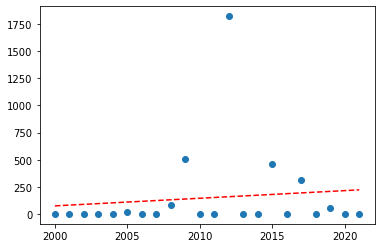

LinregressResult(slope=7.035861095426311, intercept=-13997.549186900053, rvalue=0.11326322162085689, pvalue=0.6157650060220361, stderr=13.800970906128288, intercept_stderr=27746.99015342502)
connect to engine GREENMONKEY
connect to greenmonkey engine.....GREENMONKEY and store sql table
end....
--- 0.6930367946624756 seconds ---
Time Taken: HH:MM:SS  00:00:00


In [23]:
import time ##### TESBOX for one NUTS region

import datetime
import numpy as np
import pandas as pd
from scipy import stats
start_time = time.time()
current_start_time = datetime.datetime.now()
print ("START time at greenwich:", current_start_time)

#https://stackoverflow.com/questions/71031226/calculating-trend-per-customer-level-in-python-dataframe

#https://towardsdatascience.com/adding-regression-lines-to-pandas-plots-with-scipy-2e23fd524adb

dfg = df_transformed


## group by year: ###############################################################
dfg = dfg.groupby(["year"])["drought_area"].sum().reset_index()
#################################################################################

x = dfg['year']
y=  dfg['drought_area']
#calc trend  https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.linregress.html#scipy.stats.linregress
m = stats.linregress(x, y)
slope =m.slope 
intercept=m.intercept
rvalue=m.rvalue
pvalue=m.pvalue
stderr=m.stderr
intercept_stderr=m.intercept_stderr

t = [m.slope * i + m.intercept for i in x]
#add trend value to dataframe as new column
dfg.insert(len(dfg.columns),'trend',t)
dfg.insert(len(dfg.columns),'slope',slope)
dfg.insert(len(dfg.columns),'intercept',intercept)
dfg.insert(len(dfg.columns),'rvalue',rvalue)
dfg.insert(len(dfg.columns),'pvalue',pvalue)
dfg.insert(len(dfg.columns),'stderr',stderr)
dfg.insert(len(dfg.columns),'intercept_stderr',intercept_stderr)



plt.scatter(x, y)

z = np.polyfit(x, y, 1)
p = np.poly1d(z)
plt.plot(x,p(x),"r--")

plt.show()


print (m)
#slopes = df.apply(lambda x: np.polyfit(df.index, x, 1)[0])
#x= df.groupby(['Env','Admin']).apply(lambda subdf: trendline(subdf['year'].values, subdf['drought_area'].values))

#df_group = df.groupby(["Env","year"])["drought_area"].sum().reset_index()
    


#exporting data to GREENMONKEY#################################################################################
print ("connect to engine GREENMONKEY")  #drought
engine_GREENMONKEY = sa.create_engine('mssql+pyodbc://' + "GREENMONKEY" + '/' + "Climate_Impact" + '?trusted_connection=yes&driver=ODBC+Driver+13+for+SQL+Server')
name_of_table ="C_DroughtImpact2022_TEST_TREND"       
print ("connect to greenmonkey engine.....GREENMONKEY and store sql table")  
dfg.to_sql(name_of_table, engine_GREENMONKEY, if_exists='replace', index = False, schema='drought')


############################################################################################################################################################


print ("end....")
print("--- %s seconds ---" % (time.time() - start_time))
seconds = time.time() - start_time
print('Time Taken: HH:MM:SS ', time.strftime("%H:%M:%S",time.gmtime(seconds)))





In [162]:
 ##### TESBOX for one NUTS region and EVN zone:


import time
import datetime
import numpy as np
import pandas as pd
from scipy import stats

start_time = time.time()
current_start_time = datetime.datetime.now()
print ("START time at greenwich:", current_start_time)

#https://stackoverflow.com/questions/71031226/calculating-trend-per-customer-level-in-python-dataframe

#https://towardsdatascience.com/adding-regression-lines-to-pandas-plots-with-scipy-2e23fd524adb

dfg = df_transformed



## group by year: ###############################################################
dfg2 = dfg.groupby(["Admin","Env","CLC00","CLC18","year"])["drought_area"].sum().reset_index()
#################################################################################




def model_trend_stat(row):
    y = row.drought_area
    x = row.year
    m = stats.linregress(x,y)
    slope =m.slope 
    intercept=m.intercept
    rvalue=m.rvalue
    pvalue=m.pvalue
    stderr=m.stderr
    intercept_stderr=m.intercept_stderr
    t = [m.slope * i + m.intercept for i in x]  
    #return pd.Series([rvalue,slope,intercept,pvalue,stderr])
    return pd.Series({'rvalue': rvalue, 'slope':slope,'intercept':intercept,'pvalue':pvalue,'stderr':stderr})

#dfg2.groupby(["Admin", "Env","CLC00","CLC18"]).apply(model_trend_stat).reset_index()


#dfg3[['rvalue','slope','intercept','pvalue','stderr']]= dfg2.groupby(["Admin", "Env","CLC00","CLC18"]).apply(model_trend_stat).reset_index()
dfg3= dfg2.groupby(["Admin", "Env","CLC00","CLC18"]).apply(model_trend_stat).reset_index()


#exporting data to GREENMONKEY#################################################################################
print ("connect to engine GREENMONKEY")  #drought
engine_GREENMONKEY = sa.create_engine('mssql+pyodbc://' + "GREENMONKEY" + '/' + "Climate_Impact" + '?trusted_connection=yes&driver=ODBC+Driver+13+for+SQL+Server')
name_of_table ="C_DroughtImpact2022_with_years_TEST_TREND"       
print ("connect to greenmonkey engine.....GREENMONKEY and store sql table")  
dfg2.to_sql(name_of_table, engine_GREENMONKEY, if_exists='replace', index = False, schema='drought')

########################

print ("connect to engine GREENMONKEY")  #drought
engine_GREENMONKEY = sa.create_engine('mssql+pyodbc://' + "GREENMONKEY" + '/' + "Climate_Impact" + '?trusted_connection=yes&driver=ODBC+Driver+13+for+SQL+Server')
name_of_table ="C_DroughtImpact2022_TEST_TREND"       
print ("connect to greenmonkey engine.....GREENMONKEY and store sql table")  
dfg3.to_sql(name_of_table, engine_GREENMONKEY, if_exists='replace', index = False, schema='drought')

############################################################################################################################################################


print ("end....")
print("--- %s seconds ---" % (time.time() - start_time))
seconds = time.time() - start_time
print('Time Taken: HH:MM:SS ', time.strftime("%H:%M:%S",time.gmtime(seconds)))



START time at greenwich: 2023-04-24 16:52:56.476278
connect to engine GREENMONKEY
connect to greenmonkey engine.....GREENMONKEY and store sql table
connect to engine GREENMONKEY
connect to greenmonkey engine.....GREENMONKEY and store sql table
end....
--- 5.879086494445801 seconds ---
Time Taken: HH:MM:SS  00:00:05


In [156]:
dfg3
# .groupby(["Admin", "Env","CLC00","CLC18"])

,Admin,Env,CLC00,CLC18,rvalue,slope,intercept,pvalue,stderr
0,1521,LUS,111.0,111.0,0.074913,0.001779,-3.538261,0.740397,0.005294
1,1521,LUS,112.0,112.0,0.147578,0.022976,-45.812230,0.512210,0.034431
2,1521,LUS,121.0,121.0,0.098575,0.003693,-7.358069,0.662520,0.008336
3,1521,LUS,122.0,122.0,0.051594,0.000152,-0.302422,0.819629,0.000660
4,1521,LUS,122.0,133.0,0.000000,0.000000,0.000000,1.000000,0.000000
...,...,...,...,...,...,...,...,...,...
334,1521,MDN,334.0,324.0,0.071032,0.051863,-102.670819,0.753429,0.162851
335,1521,MDN,334.0,334.0,0.066390,0.011011,-21.727979,0.769106,0.037003
336,1521,MDN,334.0,512.0,0.223574,0.000294,-0.588504,0.317225,0.000286
337,1521,MDN,511.0,511.0,0.070512,0.018577,-36.913755,0.755184,0.058765


In [111]:

df= df_transformed

for groupid, grp in data.groupby('Env'):
    print(groupid)
    model = sm.OLS(grp['y'], sm.add_constant(grp['x'])).fit()
    data.loc[data['Env'].eq(groupid), 'alpha'] = model.params['const']
    data.loc[data['Env'].eq(groupid), 'beta'] = model.params['x']



,Admin,Env,CLC00,CLC18,CLC0018,AreaHa,fire_parameter_and_year,drought_area,yeart,year
0,1521,LUS,112.0,112.0,112112.0,2161.0,SMA1LINT05Area_2000,0.0,2000,2000
1,1521,LUS,142.0,122.0,142122.0,2.0,SMA1LINT05Area_2000,0.0,2000,2000
2,1521,LUS,221.0,121.0,221121.0,13.0,SMA1LINT05Area_2000,0.0,2000,2000
3,1521,LUS,222.0,133.0,222133.0,4.0,SMA1LINT05Area_2000,0.0,2000,2000
4,1521,LUS,311.0,324.0,311324.0,324.0,SMA1LINT05Area_2000,0.0,2000,2000
...,...,...,...,...,...,...,...,...,...,...
7453,1521,MDN,322.0,131.0,322131.0,3.0,SMA1LINT05Area_2021,0.0,2021,2021
7454,1521,MDN,322.0,221.0,322221.0,190.0,SMA1LINT05Area_2021,0.0,2021,2021
7455,1521,MDN,323.0,323.0,323323.0,17469.0,SMA1LINT05Area_2021,0.0,2021,2021
7456,1521,MDN,323.0,242.0,323242.0,15.0,SMA1LINT05Area_2021,0.0,2021,2021


In [56]:
group_predictions(df, 2022)

AttributeError: 'DataFrame' object has no attribute 'date'

In [ ]:
new_lcf_group_datasource = (
'''SELECT [Admin], Env, CLC00, CLC18, CLC0018, 
 SMA1LINT05Area_2000, SMA1LINT05Area_2001, SMA1LINT05Area_2002, SMA1LINT05Area_2003, 
 SMA1LINT05Area_2004, SMA1LINT05Area_2005, SMA1LINT05Area_2006, SMA1LINT05Area_2007, SMA1LINT05Area_2008,
 SMA1LINT05Area_2009, SMA1LINT05Area_2010, SMA1LINT05Area_2011, SMA1LINT05Area_2012, SMA1LINT05Area_2013, 
 SMA1LINT05Area_2014, SMA1LINT05Area_2015, SMA1LINT05Area_2016, SMA1LINT05Area_2017, SMA1LINT05Area_2018,
 SMA1LINT05Area_2019, SMA1LINT05Area_2020, SMA1LINT05Area_2021, 
 AreaHa
  FROM [Climate_Impact].[drought].[C_DroughtImpact2022_assessment_version_v1]

LEFT JOIN..................
)
  ''')